In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  
import math
import time
import seaborn as sn

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import Ridge
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold



warnings.filterwarnings('ignore')

In [116]:
#load data

x_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
x_train = x_train.drop('id', axis = 1)
y_train = y_train.drop('id', axis = 1)

x_test = pd.read_csv('X_test.csv')
x_test =x_test.drop('id', axis = 1)

#insert column medians instead of NaN's
x_train = x_train.fillna(x_train.median())

#x_train = pd.DataFrame(x_train, columns = x_train.columns) 
#note: x_train is now the rescaled original data

Description: outlier detection via ISO Forest followed by feature sel and subseq random for regression 

In [117]:
#rescale data 
scaler = StandardScaler()
x_train_rescaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_rescaled, columns = x_train.columns) 
#x_train.head()

In [46]:
#outlier detection 
#method: IsolationForest

to_model_columns = x_train.columns
clf = IsolationForest(n_estimators=200, max_samples='auto', contamination=float(.12), \
                        max_features=0.5, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(x_train[to_model_columns])

pred = clf.predict(x_train[to_model_columns])
x_train['anomaly'] = pred

is_not_outlier = x_train['anomaly']==1
##print(is_not_outlier)
x_train_filter = x_train[is_not_outlier]
x_train_filter = x_train_filter.drop('anomaly', axis = 1)
y_train_filter = y_train[is_not_outlier]

In [47]:
#feature selection

sel = SelectFromModel(RandomForestClassifier(n_estimators = 200))
sel.fit(x_train_filter, y_train_filter)
selected_feat = x_train_filter.columns[(sel.get_support())]
x_train_filter = x_train_filter.loc[:,selected_feat]
x_test = x_test.loc[:,selected_feat]

In [49]:
#regression fit via ran For

model = RandomForestRegressor(n_estimators = 200).fit(y = y_train_filter, X = x_train_filter)
scores = cross_val_score(estimator = model, X = x_train_filter, y = y_train_filter,
                         scoring = 'r2', cv = 10) 
print("Mean Validation score {}".format(np.mean(scores)))
print("Std Validation score {}".format(np.std(scores)))

Mean Validation score 0.4158163279627239
Std Validation score 0.09655867424070073


Update: outlier detection via PCA (~90% of variance) followed by feature sel and subseq random for regression on orignal data with no outliers 

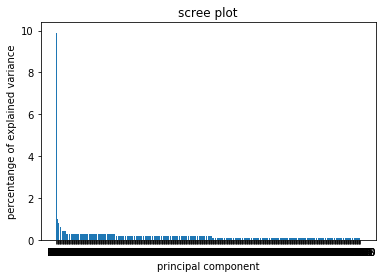

0.9065053608013854


In [118]:
#fit PCA on original rescaled data

pca = PCA(n_components=440)
x_train_pca = pca.fit_transform(x_train)
x_pca = pd.DataFrame(data = x_train_pca)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]
plt.bar(x = range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('percentange of explained variance')
plt.xlabel('principal component')
plt.title('scree plot')
plt.show()

x_train_pca = pd.DataFrame(x_train_pca, columns = np.arange(440)) 
print(sum(pca.explained_variance_ratio_))

In [120]:
#outlier detection 
#method: IsolationForest on PCA compressed data 

to_model_columns = x_train_pca.columns
clf = IsolationForest(n_estimators = 200, max_samples='auto', contamination=float(.12), \
                        max_features=0.8, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(x_train_pca[to_model_columns])

pred = clf.predict(x_train_pca[to_model_columns])
x_train_pca['anomaly'] = pred

is_not_outlier = x_train_pca['anomaly']==1
##print(is_not_outlier)
x_train_filter = x_train[is_not_outlier]
y_train_filter = y_train[is_not_outlier]

In [114]:
#feature selection 

sel = SelectFromModel(RandomForestClassifier(n_estimators = 200))
sel.fit(x_train_filter, y_train_filter)
selected_feat = x_train_filter.columns[(sel.get_support())]
x_train_filter = x_train_filter.loc[:,selected_feat]
x_test = x_test.loc[:,selected_feat]

In [115]:
#regression fit via ran For

model = RandomForestRegressor(n_estimators = 200).fit(y = y_train_filter, X = x_train_filter)
scores = cross_val_score(estimator = model, X = x_train_filter, y = y_train_filter,
                         scoring = 'r2', cv = 10) 
print("Mean Validation score {}".format(np.mean(scores)))
print("Std Validation score {}".format(np.std(scores)))

Mean Validation score 0.4785508242131611
Std Validation score 0.07864986821730291


Update: rescale data, perform PCA, remove outliers from original unscaled via IS forest, take log of original filtered data, do feature selection, fit model (rand For)

In [171]:
#load data

x_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
x_train = x_train.drop('id', axis = 1)
y_train = y_train.drop('id', axis = 1)

x_test = pd.read_csv('X_test.csv')
x_test =x_test.drop('id', axis = 1)

#insert column medians instead of NaN's
x_train = x_train.fillna(x_train.median())

is_positive = (x_train > 0).all(axis = 0)
columns_positive = x_train.columns[is_positive.values]
x_train = x_train.loc[:,columns_positive]

#rescale data 
scaler = StandardScaler()
x_train_rescaled = scaler.fit_transform(x_train)
x_train_rescaled = pd.DataFrame(x_train_rescaled, columns = x_train.columns) 
#x_train.head()

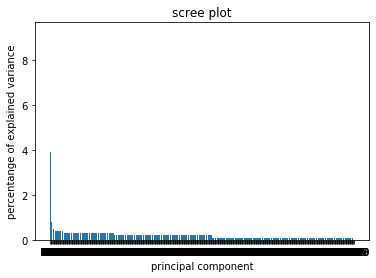

0.9073149522318885


In [172]:
#fit PCA on original rescaled data

pca = PCA(n_components=440)
x_train_pca = pca.fit_transform(x_train_rescaled)
x_pca = pd.DataFrame(data = x_train_pca)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]
plt.bar(x = range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('percentange of explained variance')
plt.xlabel('principal component')
plt.title('scree plot')
plt.show()

x_train_pca = pd.DataFrame(x_train_pca, columns = np.arange(440)) 
print(sum(pca.explained_variance_ratio_))

In [173]:
#outlier detection 
#method: IsolationForest on PCA compressed data 

to_model_columns = x_train_pca.columns
clf = IsolationForest(n_estimators = 200, max_samples='auto', contamination=float(.12), \
                        max_features=0.8, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(x_train_pca[to_model_columns])

pred = clf.predict(x_train_pca[to_model_columns])
x_train_pca['anomaly'] = pred

is_not_outlier = x_train_pca['anomaly']==1
##print(is_not_outlier)
x_train_filter = x_train[is_not_outlier]
y_train_filter = y_train[is_not_outlier]

In [174]:
#take log of x_train_filter
x_train_filter_log = x_train_filter.apply(np.log)
scaler = StandardScaler()
x_train_filter_log = scaler.fit_transform(x_train_filter_log)
x_train_filter_log = pd.DataFrame(x_train_filter_log, columns = x_train.columns) 

In [175]:
#feature selection 

sel = SelectFromModel(RandomForestClassifier(n_estimators = 200))
sel.fit(x_train_filter_log, y_train_filter)
selected_feat = x_train_filter_log.columns[(sel.get_support())]
x_train_filter_log = x_train_filter_log.loc[:,selected_feat]
x_test = x_test.loc[:,selected_feat]

In [176]:
model = RandomForestRegressor(n_estimators = 200).fit(y = y_train_filter, X = x_train_filter_log)
scores = cross_val_score(estimator = model, X = x_train_filter_log, y = y_train_filter,
                         scoring = 'r2', cv = 10) 
print("Mean Validation score {}".format(np.mean(scores)))
print("Std Validation score {}".format(np.std(scores)))

Mean Validation score 0.38359769789231524
Std Validation score 0.0680996601225978


Update: rescale data, perform PCA, remove outliers from original unscaled via IS forest, take log of original filtered data, rescale data, do feature selection, fit model (rand For)